In [1]:
# common libraries
import sys, glob, random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# analysis related modules
from scipy.stats import entropy, spearmanr
from scipy import interp
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, roc_curve, auc, r2_score
from sklearn.model_selection import KFold, GroupKFold
from collections import Counter

In [3]:
# keras modules
import tensorflow as tf
# from keras.models import load_model

from bert.tokenization import FullTokenizer

# from keras.preprocessing.text import text_to_word_sequence, Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# from keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import plot_model
import keras_tqdm
from livelossplot.keras import PlotLossesCallback

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sjnam/anacond

In [4]:
# custom layers from external files
from layers.embeddings import BertLayer
from layers.attention import AttentionLayer
from models.build_models import *
from models.train_models import *
from utils.utils import *

In [5]:
# some option settings for Jupyter notebook and TF
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)
tf.logging.set_verbosity(tf.logging.ERROR)

In [6]:
# import spacy

In [7]:
sent_notarg = np.load("kapelner_sentences_notarg_bert_nocut.npy.npz", allow_pickle=True)
#          input_ids = bert_input_nocut[0], 
#          input_masks = bert_input_nocut[1], 
#          segment_ids = bert_input_nocut[2], 
#          targ_locs = bert_input_nocut[3], 
#          lex_features = bert_input_nocut[4], 
#          scores = bert_input_nocut[5])

In [8]:
input_ids = sent_notarg['input_ids']
input_masks = sent_notarg['input_masks']
segment_ids = sent_notarg['segment_ids']
targets = sent_notarg['targets']
targ_locs = sent_notarg['targ_locs']
lex_features = sent_notarg['lex_features']
scores = sent_notarg['scores']

In [9]:
# standard scaling lexical features
std_scaler = MinMaxScaler()
lex_features = std_scaler.fit_transform(lex_features)

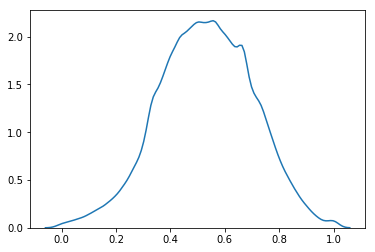

In [10]:
sns.kdeplot(np.reshape(scores, -1))

In [11]:
len(input_ids[0])

258

In [12]:
len(lex_features[0])

617

# BERT models

In [13]:
def pred_perf(pred_file_loc, true_scores, K_, gkf_split):
    _pred = [np.load(pred_file_loc+str(fold_idx)+".npy") for fold_idx in range(K_)]

    sentences_nocut_tests = [np.array(true_scores)[test_idx] \
                             for train_idx, test_idx in gkf_split]
    ret = (
        ci([rmse(trues, preds) for preds, trues in zip(_pred, sentences_nocut_tests)], digits=3) ,
        ci([1-rocauc(trues, preds,.20, "low") for preds, trues in zip(_pred, sentences_nocut_tests)], digits=3),
        ci([rocauc(trues, preds, .50, "high") for preds, trues in zip(_pred, sentences_nocut_tests)], digits=3),
        ci([rocauc(trues, preds,  .80, "high") for preds, trues in zip(_pred, sentences_nocut_tests)], digits=3))
    return(ret)

In [14]:
# some constants
RDM_SEED = 1
K_FOLDS = 10          # in the Kapelner et al.2018 paper: using 10-fold CV, based on target word grouping

MAX_SEQ_LEN = len(input_ids[0])
MAX_LEX_LEN = len(lex_features[0])

_num_iter = 3   # based on the validation data: loss is not decreasing
_batch_size = 16
_lr = 3e-5

## BERT + Attention + lexical features - nocut sentences

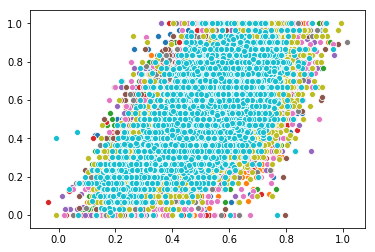

In [15]:
gkf = GroupKFold(n_splits=K_FOLDS)
gkf_split = gkf.split(input_ids, groups=targets)

fold_idx = 0
for train_idx, test_idx in tqdm_notebook(gkf_split):
    _train_input_ids = input_ids[train_idx]
    _train_input_masks = input_masks[train_idx]
    _train_segment_ids = segment_ids[train_idx]
    _train_targ_locs = targ_locs[train_idx]
    _train_lex_features = lex_features[train_idx]
    _train_scores = scores[train_idx]

    _test_input_ids = input_ids[test_idx]
    _test_input_masks = input_masks[test_idx]
    _test_segment_ids = segment_ids[test_idx]
    _test_targ_locs = targ_locs[test_idx]
    _test_lex_features = lex_features[test_idx]
    _test_scores = scores[test_idx]

#     tt_idx = 1000
#     _train_input_ids=_train_input_ids[:tt_idx]
#     _train_input_masks=_train_input_masks[:tt_idx]
#     _train_segment_ids=_train_segment_ids[:tt_idx]
#     _train_targ_locs=_train_targ_locs[:tt_idx]
#     _train_lex_features=_train_lex_features[:tt_idx]
#     _train_scores=_train_scores[:tt_idx]
#     _test_input_ids=_test_input_ids[:tt_idx]
#     _test_input_masks=_test_input_masks[:tt_idx]
#     _test_segment_ids=_test_segment_ids[:tt_idx]
#     _test_targ_locs=_test_targ_locs[:tt_idx]
#     _test_lex_features=_test_lex_features[:tt_idx]
#     _test_scores=_test_scores[:tt_idx]
    
    K.clear_session()
    sess = tf.Session()
    plot_losses = PlotLossesCallback()

    # preparing
    model_bert = build_model_bert_kapelner(MAX_SEQ_LEN, 
                                           MAX_LEX_LEN, 
                                           finetune_emb=True, attention_layer=True, 
                                           sep_cntx_targ=False, lr=_lr)
    initialize_vars(sess)
    
    # model training
    model_bert.fit(x=[_train_input_ids, _train_input_masks,
                      _train_segment_ids, _train_targ_locs,
                      _train_lex_features], 
                   y=_train_scores, 
         epochs=_num_iter, batch_size=_batch_size, 
         #validation_split=0.10, shuffle=True,
         verbose=0, 
         callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=True, leave_outer=False)]) 
                    # plot_losses])
    model_bert.save_weights("./model_weights_kapelner/bert/1emb/model_bert_notarg_wtattn_nocut_lex_cv"+str(fold_idx)+".tf")
    
    # prediction
    pred_test = model_bert.predict([_test_input_ids, _test_input_masks,
                                    _test_segment_ids, _test_targ_locs,
                                    _test_lex_features], 
                                   batch_size=_batch_size)
    pred_test = np.reshape(pred_test, -1)
    np.save("./model_predict_kapelner/bert/1emb/preds_bert_notarg_wtattn_nocut_cv_lex_"+str(fold_idx)+".npy", pred_test)
    
    fold_idx += 1
    
    sns.scatterplot(pred_test, np.reshape(_test_scores, -1))

In [16]:
gkf_split = gkf.split(input_ids, groups=targets)
pred_perf("./model_predict_kapelner/bert/1emb/preds_bert_notarg_wtattn_nocut_cv_lex_",
          np.reshape(scores, -1), K_FOLDS, gkf_split)

((0.139, 0.136, 0.142),
 (0.822, 0.814, 0.831),
 (0.782, 0.775, 0.788),
 (0.773, 0.765, 0.781))

## BERT + Attention - nocut sentences

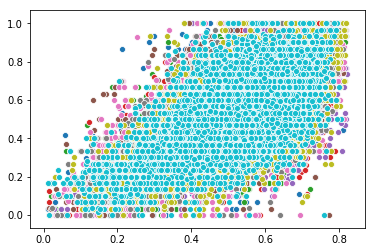

In [17]:
gkf = GroupKFold(n_splits=K_FOLDS)
gkf_split = gkf.split(input_ids, groups=targets)

fold_idx = 0
for train_idx, test_idx in tqdm_notebook(gkf_split):
    _train_input_ids = input_ids[train_idx]
    _train_input_masks = input_masks[train_idx]
    _train_segment_ids = segment_ids[train_idx]
    _train_targ_locs = targ_locs[train_idx]
    _train_lex_features = lex_features[train_idx]
    _train_scores = scores[train_idx]

    _test_input_ids = input_ids[test_idx]
    _test_input_masks = input_masks[test_idx]
    _test_segment_ids = segment_ids[test_idx]
    _test_targ_locs = targ_locs[test_idx]
    _test_lex_features = lex_features[test_idx]
    _test_scores = scores[test_idx]

#     tt_idx = 5000
#     _train_input_ids=_train_input_ids[:tt_idx]
#     _train_input_masks=_train_input_masks[:tt_idx]
#     _train_segment_ids=_train_segment_ids[:tt_idx]
#     _train_targ_locs=_train_targ_locs[:tt_idx]
#     _train_lex_features=_train_lex_features[:tt_idx]
#     _train_scores=_train_scores[:tt_idx]
#     _test_input_ids=_test_input_ids[:tt_idx]
#     _test_input_masks=_test_input_masks[:tt_idx]
#     _test_segment_ids=_test_segment_ids[:tt_idx]
#     _test_targ_locs=_test_targ_locs[:tt_idx]
#     _test_lex_features=_test_lex_features[:tt_idx]
#     _test_scores=_test_scores[:tt_idx]
    
    K.clear_session()
    sess = tf.Session()
    plot_losses = PlotLossesCallback()

    # preparing
    model_bert = build_model_bert(MAX_SEQ_LEN, 
                                  finetune_emb=True, attention_layer=True, 
                                  sep_cntx_targ=False, lr=_lr)
    initialize_vars(sess)
    
    # model training
    model_bert.fit(x=[_train_input_ids, _train_input_masks,
                      _train_segment_ids, _train_targ_locs,
                      _train_lex_features], 
                   y=_train_scores, 
         epochs=_num_iter, batch_size=_batch_size, 
         #validation_split=0.10, shuffle=True,
         verbose=0, 
         callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=True, leave_outer=False)]) 
                    # plot_losses])
    model_bert.save_weights("./model_weights_kapelner/bert/1emb/model_bert_notarg_wtattn_nocut_cv"+str(fold_idx)+".tf")
    
    # prediction
    pred_test = model_bert.predict([_test_input_ids, _test_input_masks,
                                    _test_segment_ids, _test_targ_locs,
                                    _test_lex_features], 
                                   batch_size=_batch_size)
    pred_test = np.reshape(pred_test, -1)
    np.save("./model_predict_kapelner/bert/1emb/preds_bert_notarg_wtattn_nocut_cv_"+str(fold_idx)+".npy", pred_test)
    
    fold_idx += 1
    
    sns.scatterplot(pred_test, np.reshape(_test_scores, -1))

In [16]:
gkf_split = gkf.split(input_ids, groups=targets)
pred_perf("./model_predict_kapelner/bert/1emb/preds_bert_notarg_wtattn_nocut_cv_",
          np.reshape(scores, -1), K_FOLDS, gkf_split)

((0.138, 0.136, 0.14),
 (0.816, 0.806, 0.825),
 (0.777, 0.77, 0.785),
 (0.768, 0.757, 0.778))

### full model for the downstream tasks

### /w finetune

In [15]:
K.clear_session()
sess = tf.Session()
plot_losses = PlotLossesCallback()

# preparing
model_bert = build_model_bert(MAX_SEQ_LEN, 
                              finetune_emb=True, attention_layer=True, 
                              sep_cntx_targ=False, lr=_lr)
initialize_vars(sess)

# model training
model_bert.fit(x=[input_ids, input_masks,
                  segment_ids, targ_locs,
                  lex_features], 
               y=scores, 
     epochs=_num_iter, batch_size=_batch_size, 
     #validation_split=0.10, shuffle=True,
     verbose=0, 
     callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=True, leave_outer=False)]) 
                # plot_losses])
model_bert.save_weights("model_weights_kapelner/bert/1emb/model_bert_notarg_wtattn_nocut_full222.tf")

### no tune

In [15]:
K.clear_session()
sess = tf.Session()
plot_losses = PlotLossesCallback()

# preparing
model_bert = build_model_bert(MAX_SEQ_LEN, 
                              finetune_emb=False, attention_layer=True, 
                              sep_cntx_targ=False, lr=_lr)
initialize_vars(sess)

# model training
model_bert.fit(x=[input_ids, input_masks,
                  segment_ids, targ_locs,
                  lex_features], 
               y=scores, 
     epochs=_num_iter, batch_size=_batch_size, 
     #validation_split=0.10, shuffle=True,
     verbose=0, 
     callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=True, leave_outer=False)]) 
                # plot_losses])
model_bert.save_weights("model_weights_kapelner/bert/1emb/model_bert_notune_notarg_wtattn_nocut_full.tf")

## BERT (vanilla) - nocut sentences

In [ ]:
gkf = GroupKFold(n_splits=K_FOLDS)
gkf_split = gkf.split(input_ids, groups=targets)

fold_idx = 0
for train_idx, test_idx in tqdm_notebook(gkf_split):
    _train_input_ids = input_ids[train_idx]
    _train_input_masks = input_masks[train_idx]
    _train_segment_ids = segment_ids[train_idx]
    _train_targ_locs = targ_locs[train_idx]
    _train_lex_features = lex_features[train_idx]
    _train_scores = scores[train_idx]

    _test_input_ids = input_ids[test_idx]
    _test_input_masks = input_masks[test_idx]
    _test_segment_ids = segment_ids[test_idx]
    _test_targ_locs = targ_locs[test_idx]
    _test_lex_features = lex_features[test_idx]
    _test_scores = scores[test_idx]

#     tt_idx = 1000
#     _train_input_ids=_train_input_ids[:tt_idx]
#     _train_input_masks=_train_input_masks[:tt_idx]
#     _train_segment_ids=_train_segment_ids[:tt_idx]
#     _train_targ_locs=_train_targ_locs[:tt_idx]
#     _train_lex_features=_train_lex_features[:tt_idx]
#     _train_scores=_train_scores[:tt_idx]
#     _test_input_ids=_test_input_ids[:tt_idx]
#     _test_input_masks=_test_input_masks[:tt_idx]
#     _test_segment_ids=_test_segment_ids[:tt_idx]
#     _test_targ_locs=_test_targ_locs[:tt_idx]
#     _test_lex_features=_test_lex_features[:tt_idx]
#     _test_scores=_test_scores[:tt_idx]
    
    K.clear_session()
    sess = tf.Session()
    plot_losses = PlotLossesCallback()

    # preparing
    model_bert = build_model_bert(MAX_SEQ_LEN, 
                                  finetune_emb=True, attention_layer=False, 
                                  sep_cntx_targ=False, lr=_lr)
    initialize_vars(sess)
    
    # model training
    model_bert.fit(x=[_train_input_ids, _train_input_masks,
                      _train_segment_ids, _train_targ_locs,
                      _train_lex_features], 
                   y=_train_scores, 
         epochs=_num_iter, batch_size=_batch_size, 
         #validation_split=0.10, shuffle=True,
         verbose=0, 
         callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=True, leave_outer=False)]) 
                    # plot_losses])
    model_bert.save_weights("./model_weights_kapelner/bert/1emb/model_bert_notarg_noattn_nocut_cv"+str(fold_idx)+".tf")
    
    # prediction
    pred_test = model_bert.predict([_test_input_ids, _test_input_masks,
                                    _test_segment_ids, _test_targ_locs,
                                    _test_lex_features], 
                                   batch_size=_batch_size)
    pred_test = np.reshape(pred_test, -1)
    np.save("./model_predict_kapelner/bert/1emb/preds_bert_notarg_noattn_nocut_cv_"+str(fold_idx)+".npy", pred_test)
    
    fold_idx += 1
    
    sns.scatterplot(pred_test, np.reshape(_test_scores, -1))

In [ ]:
gkf_split = gkf.split(input_ids, groups=targets)
pred_perf("./model_predict_kapelner/bert/1emb/preds_bert_notarg_noattn_nocut_cv_",
          np.reshape(scores, -1), K_FOLDS, gkf_split)